In [ ]:
pip install optuna transformers[torch] imbalanced-learn  accelerate -U

In [ ]:
import pandas as pd
import numpy as np
import torch
import random
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, accuracy_score
from transformers import BertTokenizer, BertModel, Trainer, TrainingArguments, BertForSequenceClassification, TrainerCallback, pipeline
from torch.nn import CrossEntropyLoss
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [ ]:
import torch

# Cek apakah CUDA (GPU) tersedia
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available. Using GPU.")
else:
    device = torch.device("cpu")
    print("GPU not available. Using CPU.")


GPU is available. Using GPU.


In [ ]:
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tag import pos_tag
from nltk.tree import Tree
from nltk.chunk import ne_chunk
from nltk.corpus import wordnet
from transformers import BertTokenizer, BertForMaskedLM
import torch

# Pastikan untuk mengunduh resource NLTK yang diperlukan
# Download stopwords, wordnet, POS tagger, NER chunker, dan kata-kata dari NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

# Konfigurasi model dan tokenizer
tokenizer_mlm = BertTokenizer.from_pretrained('bert-base-uncased')
model_mlm = BertForMaskedLM.from_pretrained('bert-base-uncased').eval()

# Mengatur perangkat (GPU jika tersedia)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_mlm.to(device)

# Fungsi untuk mendapatkan prediksi dari model MLM untuk satu segmen
def get_predictions_for_window(input_ids_tensor):
    input_ids_tensor = input_ids_tensor.to(device)
    with torch.no_grad():
        outputs = model_mlm(input_ids_tensor)
        predictions = outputs[0]

    # Logika untuk mengganti token berdasarkan prediksi model
    # Ini bisa disesuaikan sesuai dengan kebutuhan spesifik
    corrected_tokens = []
    for idx in range(input_ids_tensor.size(1)):
        predicted_index = torch.argmax(predictions[0, idx]).item()
        predicted_token = tokenizer_mlm.convert_ids_to_tokens([predicted_index])[0]
        corrected_tokens.append(predicted_token)

    # Menggabungkan token yang telah diperbaiki
    corrected_text = tokenizer_mlm.convert_tokens_to_string(corrected_tokens)
    return corrected_text

def correct_text_with_mlm(text, window_size=512, stride=256):
    input_ids_full = tokenizer_mlm.encode(text, add_special_tokens=True)

    corrected_text = ""
    last_overlap = ""

    for start in range(0, len(input_ids_full), stride):
        end = start + window_size
        input_ids_window = input_ids_full[start:end]
        input_ids_tensor = torch.tensor([input_ids_window]).to(device)

        window_corrected_text = get_predictions_for_window(input_ids_tensor)

        # Hanya ambil bagian non-overlap dari teks yang diperbaiki
        non_overlap_text = window_corrected_text[len(last_overlap):]

        corrected_text += non_overlap_text
        last_overlap = window_corrected_text[-stride:]

    return corrected_text.strip()


def preprocess_text(text):
    # Koreksi teks dengan MLM
    corrected_text = correct_text_with_mlm(text)

    # Jika teks setelah MLM kosong, kembalikan teks awal
    if not corrected_text.strip():
        corrected_text = text

    # Menghilangkan karakter tidak berguna
    cleaned_text = re.sub(r'[^a-zA-Z\s]', '', corrected_text, re.I|re.A)

    # Lowercasing
    lowered_text = cleaned_text.lower()

    # Menghapus whitespace
    stripped_text = lowered_text.strip()

    # Jika teks kosong setelah pembersihan, kembalikan teks awal
    if not stripped_text:
        return text

    # Tokenisasi dan POS tagging
    tokens = word_tokenize(stripped_text)

    # Stemming dan Lemmatisasi
    stemmer = PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    processed_tokens = []
    for word, tag in pos_tag(tokens):
        stemmed_word = stemmer.stem(word)
        pos = wordnet.NOUN  # Default to NOUN
        if tag.startswith('VB'):
            pos = wordnet.VERB
        elif tag.startswith('JJ'):
            pos = wordnet.ADJ
        elif tag.startswith('RB'):
            pos = wordnet.ADV
        lemmatized_word = lemmatizer.lemmatize(stemmed_word, pos)
        processed_tokens.append(lemmatized_word)

    # Menghilangkan stopwords
    filtered_tokens = [word for word in processed_tokens if word not in stopwords.words('english')]

    # Named Entity Recognition
    ne_tree = ne_chunk(pos_tag(word_tokenize(stripped_text)))
    named_entities = []
    for tagged_tree in ne_tree:
        if hasattr(tagged_tree, 'label'):
            entity_name = ' '.join(c[0] for c in tagged_tree.leaves())
            entity_type = tagged_tree.label()
            named_entities.append((entity_name, entity_type))
    named_entity_str = ' '.join([name for name, type in named_entities])

    # Gabungkan kata-kata yang telah diolah dan named entities
    final_text = ' '.join(filtered_tokens) + ' ' + named_entity_str

    # Pastikan hasil akhir tidak kosong
    return final_text if final_text.strip() else text


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'cls.seq_relationship.weight', 'bert.pooler.dense.weight', 'cls.seq_rel

In [ ]:
from transformers import BertTokenizer, BertForMaskedLM
import torch
import random

from transformers import BertTokenizer, BertForMaskedLM

# Load tokenizer dan model dengan konfigurasi GPU jika tersedia
tokenizer_mbert = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
model_mbert = BertForMaskedLM.from_pretrained('bert-base-multilingual-cased').to(device)


def get_synonyms_mbert(sentence, top_k=3, window_size=512, stride=256):
    input_ids_full = tokenizer_mbert.encode(sentence, add_special_tokens=True)

    synonyms = {}
    for start in range(0, len(input_ids_full), stride):
        end = min(start + window_size, len(input_ids_full))
        input_ids_window = input_ids_full[start:end]
        input_ids_tensor = torch.tensor([input_ids_window]).to(device)

        mask_token_index = torch.where(input_ids_tensor == tokenizer_mbert.mask_token_id)[1]

        with torch.no_grad():
            predictions = model_mbert(input_ids_tensor)[0]

        for idx, token_idx in enumerate(mask_token_index.tolist()):
            predicted_ids = predictions[0, token_idx, :].topk(top_k).indices.tolist()
            synonym_words = [tokenizer_mbert.decode([predicted_id]).strip() for predicted_id in predicted_ids]
            # Ambil kata asli dari window
            original_word = tokenizer_mbert.decode([input_ids_window[token_idx]]).strip()
            synonyms[original_word] = synonym_words

    return synonyms

def balanced_augmentation(X, y, target_class):
    majority_class_count = y.value_counts().max()
    minority_class_data = X[y == target_class]
    augmented_data = []

    while len(minority_class_data) + len(augmented_data) < majority_class_count:
        for text in minority_class_data:
            if not text.strip():  # Cek apakah teks kosong
                continue
            synonyms = get_synonyms_mbert(text)
            words = text.split()
            augmented_text = []
            for word in words:
                if word in synonyms and random.random() < 0.2:  # 20% peluang untuk menggunakan sinonim
                    augmented_text.append(random.choice(synonyms[word]))
                else:
                    augmented_text.append(word)
            augmented_sentence = ' '.join(augmented_text)
            if augmented_sentence:  # Cek apakah hasil augmentasi tidak kosong
                augmented_data.append(augmented_sentence)
            if len(minority_class_data) + len(augmented_data) >= majority_class_count:
                break

    X_augmented = pd.concat([X, pd.Series(augmented_data)])
    y_augmented = pd.concat([y, pd.Series([target_class] * len(augmented_data))])
    return X_augmented, y_augmented

# Fungsi untuk visualisasi distribusi label
def visualize_label_distribution(y_before, y_after, title_before='Before Balancing', title_after='After Balancing'):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
    sns.countplot(x=y_before, ax=axes[0])
    axes[0].set_title(title_before)
    axes[0].set_xlabel('Label')
    axes[0].set_ylabel('Count')
    sns.countplot(x=y_after, ax=axes[1])
    axes[1].set_title(title_after)
    axes[1].set_xlabel('Label')
    axes[1].set_ylabel('Count')
    plt.tight_layout()
    plt.show()

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'cls.seq_relationship.weight', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# Load dataset
data = pd.read_csv('/content/drive/MyDrive/processed.csv')
data['OCR_Text'] = data['OCR_Text'].apply(preprocess_text)

Token indices sequence length is longer than the specified maximum sequence length for this model (587 > 512). Running this sequence through the model will result in indexing errors


In [ ]:
data.to_csv('/content/drive/MyDrive/preprocessed.csv',index=False)

In [ ]:
data

,Image URL,Timestamp,Filename,OCR_Text,Perusahaan tidak jelas atau tidak ada informasi valid (40%),"Deskripsi posisi, persyaratan, dan lokasi kerja yang tidak jelas (25%)",Deskripsi pekerjaan tidak spesifik (Jobdesc) (20%),Tidak ada proses wawancara dan seleksi yang jelas(5%),Ada permintaan biaya pendaftaran(5%),Gaji tidak realistis (5%),Total,Label,Extracted_Companies,semantic_validate,cleaned_OCR_text,tokenized_segments,processed_text
0,https://scontent-xsp2-1.cdninstagram.com/v/t51...,2022-12-28T07:12:37.000Z,2022-12-28_post_lokermagang0_image.jpg,uwfo malang sugarnut indonesia program magang ...,0.4,0.25,0.2,0.00,0.0,0.0,0.85,Fraud,Sugarnutsco,NaN,UWFO MALANG SUGARNUTS INDONESIA PROGRAM MAGANG...,"[[101, 158, 83695, 11403, 27277, 44376, 34065,...",[CLS] UWFO MALANG SUGARNUTS INDONESIA PROGRAM ...
1,https://scontent-xsp1-3.cdninstagram.com/v/t51...,2022-12-26T08:03:04.000Z,2022-12-26_post_lokermagang1_combined.jpg,k psi psi jakarta magang psi kembai dibuka kam...,0.4,0.00,0.2,0.00,0.0,0.0,0.60,Not-Fraud,PSI,NaN,WFO JAKARTA PSI PSI JAKARTA PROGRAM MAGANG PSI...,"[[101, 160, 11565, 11403, 53399, 67813, 46935,...",[CLS] WFO JAKARTA PSI PSI JAKARTA PROGRAM MAGA...
2,https://instagram.fsub8-2.fna.fbcdn.net/v/t51....,2022-12-26T05:05:33.000Z,2022-12-26_post_lokermagang2_combined.jpg,fh fulltim asia land ye mungkin ini buat kamu ...,0.0,0.00,0.0,0.00,0.0,0.0,0.00,Not-Fraud,Asia Land,PT Jakarta Land,WFH FULLTIME Asia Land YES MUNGKIN INI BUAT KA...,"[[101, 160, 11565, 12396, 143, 100673, 11369, ...",[CLS] WFH FULLTIME Asia Land YES MUNGKIN INI B...
3,https://instagram.fsub8-2.fna.fbcdn.net/v/t51....,2022-12-24T06:54:18.000Z,2022-12-24_post_lokermagang3_image.jpg,hybrid semarang hercodigit open internshiraabu...,0.0,0.00,0.2,0.00,0.0,0.0,0.20,Not-Fraud,Herco Digital Indonesia,PT Herco Digital Indonesia,HYBRID SEMARANG hercodigital OPEN INTERNSHIBer...,"[[101, 145, 14703, 11274, 46876, 11490, 23056,...",[CLS] HYBRID SEMARANG hercodigital OPEN INTERN...
4,https://instagram.fsub8-1.fna.fbcdn.net/v/t51....,2022-12-22T10:00:46.000Z,2022-12-22_post_lokermagang4_image.jpg,wfh onlin kltc anud ji aershioi puka iu e yov ...,0.4,0.00,0.0,0.00,0.0,0.0,0.40,Not-Fraud,KLTC,NaN,UWFH ONLINE KLTC Anude Jiraorshioifalieaiaiu 6...,"[[101, 158, 83695, 12396, 49339, 11369, 83198,...",[CLS] UWFH ONLINE KLTC Anude Jiraorshioifaliea...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2889,https://instagram.fmlg11-1.fna.fbcdn.net/v/t51...,2022-01-13T15:53:46.000Z,2022-01-13_post_info_loker.indonesia44_image.jpg,berka yang dibagah perusahaan yang daak di sur...,0.4,0.00,0.2,0.00,0.0,0.0,0.60,Not-Fraud,NaN,NaN,RECRUITMENT BeRKAS YANG DibawaH Perusahaan yan...,"[[101, 71033, 10858, 11273, 83259, 55032, 5065...",[CLS] RECRUITMENT BeRKAS YANG DibawaH Perusaha...
2890,https://instagram.fmlg11-1.fna.fbcdn.net/v/t51...,2022-01-13T14:25:44.000Z,2022-01-13_post_info_loker.indonesia45_image.jpg,solid wk hire appli posisi consult market staf...,0.0,0.25,0.2,0.00,0.0,0.0,0.45,Not-Fraud,PT SOLID WK,PT Solid Logistics,PT SOLID WK WE ARE HIRING APPLY NOW Posisi Con...,"[[101, 30350, 71020, 11369, 28895, 41107, 160,...",[CLS] PT SOLID WK WE ARE HIRING APPLY NOW Posi...
2891,https://instagram.fmlg11-1.fna.fbcdn.net/v/t51...,2022-01-13T14:22:00.000Z,2022-01-13_post_info_loker.indonesia46_image.jpg,af designo bagan potan sayan kermaria helper p...,0.4,0.00,0.2,0.00,0.0,0.0,0.60,Not-Fraud,RESTORAN WAJIR SEAFOOD,PT/Restoran,We af hiring Designo BAGIAN POTONG SAYUR KERIT...,"[[101, 12865, 10452, 55356, 10376, 17732, 1013...",[CLS] We af hiring Designo BAGIAN POTONG SAYUR...
2892,https://instagram.fmlg11-1.fna.fbcdn.net/v/t51...,2022-01-13T14:17:49.000Z,2022-01-13_post_info_loker.indonesia47_image.jpg,program mcf maf kami sedang merekrut posisi cr...,0.0,0.00,0.2,0.05,0.0,0.0,0.25,Not-Fraud,PT MCF Cabang Rantau Prapat,PT MCF,InHouse Program MCF MAF Kami Sedang Merekrut ...,"[[101, 10167, 12396, 36202, 13715, 24650, 1156...",[CLS] InHouse Program MCF MAF Kami

Token indices sequence length is longer than the specified maximum sequence length for this model (620 > 512). Running this sequence through the model will result in indexing errors


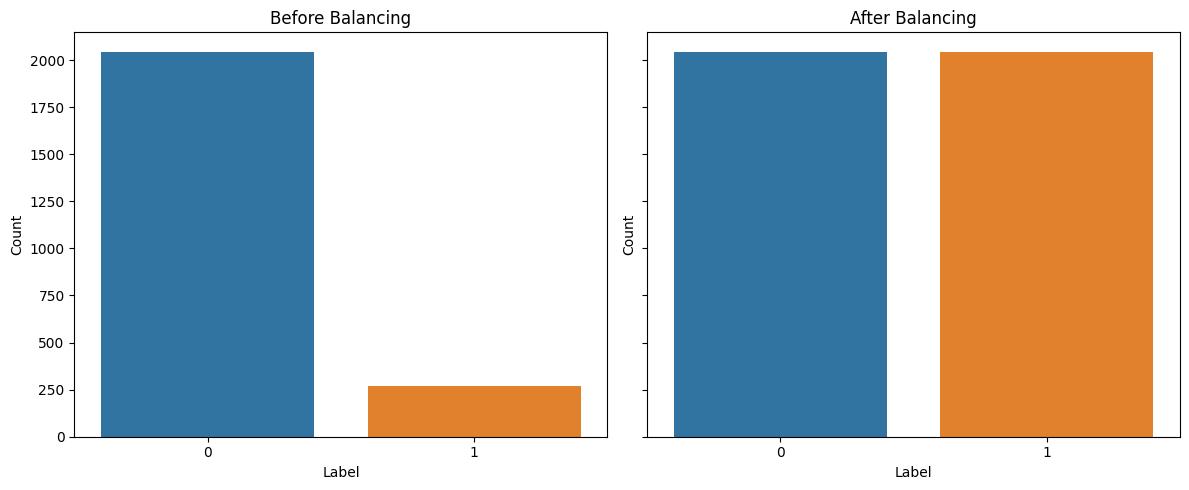

In [ ]:
# Konversi label ke numerik
label_mapping = {'Not-Fraud': 0, 'Fraud': 1}
data['Label'] = data['Label'].map(label_mapping)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(data['OCR_Text'], data['Label'], test_size=0.2, stratify=data['Label'], random_state=42)

# Menentukan kelas minoritas
minority_class = y_train.value_counts().idxmin()

# Melakukan augmentasi sampai distribusi label seimbang
X_train_balanced, y_train_balanced = balanced_augmentation(X_train, y_train, minority_class)

# Visualisasi distribusi label sebelum dan sesudah augmentasi
visualize_label_distribution(y_train, y_train_balanced)

In [ ]:
# Load mBERT
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
model = BertModel.from_pretrained('bert-base-multilingual-cased')

In [ ]:
# Pisahkan data augmentasi dari data asli
augmented_samples = X_train_balanced[len(X_train):]

# Reset indeks untuk memudahkan penggabungan
X_train_reset = X_train.reset_index(drop=True)
augmented_samples_reset = augmented_samples.reset_index(drop=True)
# Membuat DataFrame untuk perbandingan
comparison_df = pd.DataFrame({
    "Original Text": X_train_reset,
    "Augmented Text": augmented_samples_reset
})

# Tampilkan beberapa sampel dari DataFrame
comparison_df.sample(5)

,Original Text,Augmented Text
727,ki n g ft hiring operator kualifikasi usia mak...,camulia grouwe hiring pt pancamulia pratama dj...
985,house beauty marcomm manager mm kualifikasi wa...,lowongaan kerja dibutuhkan guru sassa jepang l...
100,p avdhennc hiring dibutuhkan cepat staff toko ...,hiring kasir waiter cooking helper kualingkasi...
1319,hy lowongan kerja waitressi steward tanjung du...,finte interior designer mafinte memban lowunga...
251,hiring kami merupakan perusahaan yang bergerak...,orlin grosis admin perancang busan menguasai m...


In [ ]:
import pandas as pd
import numpy as np
import torch
import random
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, accuracy_score
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
from torch.nn import CrossEntropyLoss

# Mendefinisikan kelas TextDataset yang merupakan subclass dari Dataset
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=512):  # Konstruktor kelas dengan teks, label, tokenizer, dan panjang maksimum
        self.texts = texts  # Teks input
        self.labels = labels  # Label kelas
        self.tokenizer = tokenizer  # Tokenizer BERT
        self.max_len = max_len  # Panjang maksimum input teks

    def __len__(self):
        return len(self.texts)  # Mengembalikan jumlah teks

    def __getitem__(self, idx):  # Mendapatkan item pada index tertentu
        text = str(self.texts.iloc[idx])  # Teks pada index tertentu
        labels = self.labels.iloc[idx]  # Label pada index tertentu
        encoding = self.tokenizer.encode_plus(
          text,
          add_special_tokens=True,  # Menambahkan token khusus seperti [CLS] dan [SEP]
          max_length=self.max_len,  # Memastikan panjang maksimum teks
          truncation=True,  # Memotong teks jika melebihi panjang maksimum
          padding='max_length',  # Padding teks hingga panjang maksimum
          return_attention_mask=True,  # Mengembalikan attention mask
          return_tensors='pt',  # Mengembalikan tensor PyTorch
        )
        return {
          'input_ids': encoding['input_ids'].flatten(),  # Mengembalikan input IDs
          'attention_mask': encoding['attention_mask'].flatten(),  # Mengembalikan attention mask
          'labels': torch.tensor(labels, dtype=torch.long)  # Mengembalikan label sebagai tensor
        }

# Mempersiapkan dataset untuk pelatihan dan pengujian
train_dataset = TextDataset(X_train_balanced, y_train_balanced, tokenizer)
test_dataset = TextDataset(X_test, y_test, tokenizer)

# Menghitung bobot kelas untuk menangani ketidakseimbangan kelas
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_balanced), y=y_train_balanced)
class_weights = torch.tensor(class_weights, dtype=torch.float)  # Mengonversi bobot kelas menjadi tensor PyTorch

# Mendefinisikan kelas CustomTrainer yang merupakan subclass dari Trainer
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):  # Fungsi untuk menghitung loss
        labels = inputs.pop("labels")  # Mengambil label dari input
        outputs = model(**inputs)  # Mendapatkan output dari model
        logits = outputs.logits  # Logits dari output
        loss_fct = CrossEntropyLoss(weight=class_weights.to(logits.device))  # Fungsi loss dengan bobot kelas
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))  # Menghitung loss
        return (loss, outputs) if return_outputs else loss  # Mengembalikan loss dan output

# Fungsi untuk menghitung metrik evaluasi model berdasarkan prediksi.
def compute_metrics(pred):
    labels = pred.label_ids  # Label asli.
    preds = pred.predictions.argmax(-1)  # Prediksi model.
    # Menghitung precision, recall, f1-score, dan AUC.
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    auc = roc_auc_score(labels, preds)
    accuracy = accuracy_score(labels, preds)
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': auc,
        'accuracy': accuracy
    }


In [ ]:
from transformers import TrainerCallback, TrainingArguments, Trainer
from transformers import BertForSequenceClassification
import optuna

all_loss_histories = {}

class LossHistory(TrainerCallback):
    def __init__(self):
        self.train_loss = []
        self.eval_loss = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if 'loss' in logs:  # Training loss
            self.train_loss.append(logs['loss'])
        if 'eval_loss' in logs:  # Validation loss
            self.eval_loss.append(logs['eval_loss'])

In [ ]:
def model_save_path(trial_number):
    return f"/content/model_trial_{trial_number}"

def results_save_path(trial_number):
    return f"/content/results_trial_{trial_number}"

def logs_save_path(trial_number):
    return f"/content/logs_trial_{trial_number}"


# Inisialisasi model di setiap trial
model = BertForSequenceClassification.from_pretrained(
        'bert-base-multilingual-cased', num_labels=2)

def objective(trial):
    # Definisikan rentang hyperparameter
    weight_decay = trial.suggest_float("weight_decay", 0.05, 0.06)
    adam_epsilon = trial.suggest_float("adam_epsilon", 7.5e-7, 8e-7)
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 5e-5)
    num_train_epochs = trial.suggest_int("num_train_epochs", 4, 8)
    per_device_train_batch_size = trial.suggest_categorical("per_device_train_batch_size", [28, 30, 32, 34, 36])
    warmup_steps = trial.suggest_int("warmup_steps", 1000, 1500)
    gradient_accumulation_steps = trial.suggest_categorical("gradient_accumulation_steps", [3, 4, 5, 6, 7])
    loss_history = LossHistory()
    # Training arguments
    training_args = TrainingArguments(
        output_dir=f'/content/results_trial_{trial.number}',
        num_train_epochs=num_train_epochs,
        per_device_train_batch_size=per_device_train_batch_size,
        per_device_eval_batch_size=32,
        learning_rate=learning_rate,
        warmup_steps=warmup_steps,
        weight_decay=weight_decay,
        logging_dir=f'./logs_trial_{trial.number}',
        evaluation_strategy="epoch",
        save_strategy="epoch",
        save_total_limit=1,
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        report_to="none"
    )

    # Inisialisasi Trainer dengan custom loss function
    trainer = CustomTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=compute_metrics,
        callbacks=[LossHistory()]
    )

    # Train model
    trainer.train()
    # Simpan model setelah trial
    trial_model_path = model_save_path(trial.number)
    model.save_pretrained(trial_model_path)

    # Evaluasi model
    eval_results = trainer.evaluate()
    # Simpan riwayat loss untuk trial ini
    all_loss_histories[trial.number] = {
        "train_loss": loss_history.train_loss,
        "eval_loss": loss_history.eval_loss
    }

    return (eval_results['eval_f1']+eval_results)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import shutil
import os
import optuna


# Fungsi untuk menghapus direktori dari semua trial kecuali trial terbaik
def delete_all_but_best_trial_files(best_trial_number):
    for trial_number in range(NUM_TRIALS):
        if trial_number != best_trial_number:
            paths_to_remove = [
                model_save_path(trial_number),
                results_save_path(trial_number),
                logs_save_path(trial_number)
            ]
            for path in paths_to_remove:
                if os.path.exists(path):
                    shutil.rmtree(path)

# Membuat study Optuna
study = optuna.create_study(direction="maximize")

NUM_TRIALS = 2
trial_number = 0
while True:
    study.optimize(objective, n_trials=1)
    current_best_trial_number = study.best_trial.number

    # Hapus direktori dari semua trial kecuali yang terbaik
    delete_all_but_best_trial_files(current_best_trial_number)

    trial_number += 1

    # Cek apakah nilai terbaik sudah mencapai atau melebihi 0.75 atau jumlah trial sudah mencapai batas
    if study.best_trial.value >= 0.75 or trial_number >= NUM_TRIALS:
        break
    else:
        # Tambah batas trial jika nilai terbaik belum mencapai 70
        NUM_TRIALS += 1

print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))


[I 2023-12-24 18:18:28,559] A new study created in memory with name: no-name-001f197e-4703-4efe-840c-9270b8a3d8c7


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Roc Auc,Accuracy
1,No log,0.576150,0.205357,0.676471,0.315068,0.664067,0.654577
2,No log,0.492930,0.328571,0.676471,0.442308,0.746259,0.799655
3,No log,0.560438,0.284091,0.735294,0.409836,0.744359,0.751295
4,0.531000,0.391822,0.459184,0.661765,0.542169,0.779023,0.868739
5,0.531000,0.382886,0.487805,0.588235,0.533333,0.753022,0.879102
6,0.531000,0.382264,0.529412,0.529412,0.529412,0.733395,0.889465


[I 2023-12-24 18:29:05,876] Trial 0 finished with value: 0.5532975783150361 and parameters: {'weight_decay': 0.05431343517024041, 'adam_epsilon': 7.634144527849141e-07, 'learning_rate': 1.747659911922478e-05, 'num_train_epochs': 6, 'per_device_train_batch_size': 32, 'warmup_steps': 1242, 'gradient_accumulation_steps': 7}. Best is trial 0 with value: 0.5532975783150361.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Roc Auc,Accuracy
1,No log,0.339193,0.520548,0.558824,0.539007,0.745165,0.887737
2,No log,0.375620,0.548780,0.661765,0.600000,0.794679,0.896373
3,No log,0.353070,0.541667,0.573529,0.557143,0.754475,0.892919
4,No log,0.371075,0.546875,0.514706,0.530303,0.728977,0.892919
5,0.181900,0.400236,0.552239,0.544118,0.548148,0.742705,0.894646
6,0.181900,0.426187,0.532258,0.485294,0.507692,0.714271,0.889465


[I 2023-12-24 18:39:32,206] Trial 1 finished with value: 0.6113525547205184 and parameters: {'weight_decay': 0.05682922613806341, 'adam_epsilon': 7.79770215467185e-07, 'learning_rate': 2.195430920888019e-05, 'num_train_epochs': 6, 'per_device_train_batch_size': 38, 'warmup_steps': 1567, 'gradient_accumulation_steps': 8}. Best is trial 1 with value: 0.6113525547205184.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Roc Auc,Accuracy
1,No log,0.380143,0.506494,0.573529,0.537931,0.749583,0.884283
2,No log,0.373378,0.534247,0.573529,0.553191,0.753497,0.891192
3,No log,0.478280,0.465909,0.602941,0.525641,0.755482,0.872193
4,0.130400,0.441097,0.540984,0.485294,0.511628,0.715250,0.891192


[I 2023-12-24 18:46:39,400] Trial 2 finished with value: 0.5639557265634321 and parameters: {'weight_decay': 0.05222036186573635, 'adam_epsilon': 7.79294785453474e-07, 'learning_rate': 1.7454330617829473e-05, 'num_train_epochs': 4, 'per_device_train_batch_size': 32, 'warmup_steps': 1206, 'gradient_accumulation_steps': 6}. Best is trial 1 with value: 0.6113525547205184.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Roc Auc,Accuracy
1,No log,0.361915,0.552239,0.544118,0.548148,0.742705,0.894646
2,No log,0.407955,0.532468,0.602941,0.565517,0.766246,0.891192
3,No log,0.392997,0.520548,0.558824,0.539007,0.745165,0.887737
4,No log,0.419076,0.506667,0.558824,0.531469,0.743208,0.884283
5,0.122000,0.386313,0.573770,0.514706,0.542636,0.731913,0.898100


[I 2023-12-24 18:55:22,268] Trial 3 finished with value: 0.5764636062266192 and parameters: {'weight_decay': 0.05243016063161965, 'adam_epsilon': 7.888448056867043e-07, 'learning_rate': 2.3111170842230888e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 40, 'warmup_steps': 1476, 'gradient_accumulation_steps': 6}. Best is trial 1 with value: 0.6113525547205184.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Roc Auc,Accuracy
1,No log,0.403145,0.569231,0.544118,0.556391,0.744662,0.898100
2,No log,0.435453,0.528571,0.544118,0.536232,0.739769,0.889465


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Roc Auc,Accuracy
1,No log,0.403145,0.569231,0.544118,0.556391,0.744662,0.898100
2,No log,0.435453,0.528571,0.544118,0.536232,0.739769,0.889465
3,No log,0.495269,0.482353,0.602941,0.535948,0.758418,0.877375
4,0.083700,0.457214,0.546875,0.514706,0.530303,0.728977,0.892919


[I 2023-12-24 19:02:30,795] Trial 4 finished with value: 0.5670289997758294 and parameters: {'weight_decay': 0.052076176948886166, 'adam_epsilon': 7.829510251675228e-07, 'learning_rate': 1.6494977602551115e-05, 'num_train_epochs': 4, 'per_device_train_batch_size': 32, 'warmup_steps': 1535, 'gradient_accumulation_steps': 6}. Best is trial 1 with value: 0.6113525547205184.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Roc Auc,Accuracy
1,No log,0.395958,0.550000,0.485294,0.515625,0.716228,0.892919
2,No log,0.405120,0.571429,0.529412,0.549618,0.738287,0.898100
3,No log,0.407697,0.552239,0.544118,0.548148,0.742705,0.894646
4,No log,0.395036,0.551724,0.470588,0.507937,0.709854,0.892919
5,0.102200,0.421907,0.551724,0.470588,0.507937,0.709854,0.892919
6,0.102200,0.447974,0.578947,0.485294,0.528000,0.719164,0.898100


[I 2023-12-24 19:12:59,676] Trial 5 finished with value: 0.5601652791201182 and parameters: {'weight_decay': 0.052155270480626896, 'adam_epsilon': 7.857463861395967e-07, 'learning_rate': 1.8003500774175813e-05, 'num_train_epochs': 6, 'per_device_train_batch_size': 38, 'warmup_steps': 1337, 'gradient_accumulation_steps': 6}. Best is trial 1 with value: 0.6113525547205184.


Epoch,Training Loss,Validation Loss


[W 2023-12-24 19:13:53,925] Trial 6 failed with parameters: {'weight_decay': 0.056434881801310455, 'adam_epsilon': 7.69363639326359e-07, 'learning_rate': 2.020495910390479e-05, 'num_train_epochs': 6, 'per_device_train_batch_size': 34, 'warmup_steps': 1472, 'gradient_accumulation_steps': 7} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-95-7b712a03c4ed>", line 55, in objective
    trainer.train()
  File "/usr/local/lib/python3.10/dist-packages/transformers/trainer.py", line 1537, in train
    return inner_training_loop(
  File "/usr/local/lib/python3.10/dist-packages/transformers/trainer.py", line 1859, in _inner_training_loop
    and (torch.isnan(tr_loss_step) or torch.isinf(tr_loss_step))
KeyboardInterrupt
[W 2023-12-24 19:13:53,926] Trial 6 failed with value None.


KeyboardInterrupt: ignored

In [ ]:
import shutil
import os

def copy_directory_contents(src, dst):
    if not os.path.exists(dst):
        os.makedirs(dst)
    for item in os.listdir(src):
        s = os.path.join(src, item)
        d = os.path.join(dst, item)
        if os.path.isdir(s):
            shutil.copytree(s, d, dirs_exist_ok=True)
        else:
            shutil.copy2(s, d)

source_model_path = '/content/model_trial_{number}'.format(number=study.best_trial.number)
destination_model_path = '/content/drive/MyDrive/job-fraud-ads/model_best_fix_5'

# Salin isi dari source ke destination
copy_directory_contents(source_model_path, destination_model_path)

print(f"Model telah dipindahkan ke {destination_model_path}")


Model telah dipindahkan ke /content/drive/MyDrive/job-fraud-ads/model_best_fix_5


In [ ]:
import torch
from transformers import BertForSequenceClassification
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Muat model terbaik
model_path = '/content/drive/MyDrive/job-fraud-ads/model_best_fix_5'  # Ganti dengan path model terbaik Anda
model = BertForSequenceClassification.from_pretrained(model_path, num_labels=2)
model.eval()

# Mempersiapkan DataLoader untuk dataset uji
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32)  # Sesuaikan batch size

# Inisialisasi variabel untuk menyimpan metrik
metrics = {'precision': [], 'recall': [], 'f1_score': [], 'roc_auc': [], 'accuracy': []}

# Evaluasi model
true_labels = []
predictions = []
probabilities = []

for batch in test_loader:
    inputs = {
        'input_ids': batch['input_ids'],
        'attention_mask': batch['attention_mask']
    }
    labels = batch['labels']

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    probs = torch.softmax(logits, dim=1)
    predicted_labels = torch.argmax(logits, dim=1)
    predictions.extend(predicted_labels.tolist())
    true_labels.extend(labels.tolist())
    probabilities.extend(probs[:, 1].tolist())  # Probabilitas label positif

# Menghitung metrik
metrics['precision'].append(precision_score(true_labels, predictions))
metrics['recall'].append(recall_score(true_labels, predictions))
metrics['f1_score'].append(f1_score(true_labels, predictions))
metrics['roc_auc'].append(roc_auc_score(true_labels, probabilities))
metrics['accuracy'].append(accuracy_score(true_labels, predictions))

# Cetak atau visualisasikan metrik
print(metrics)

{'precision': [0.5487804878048781], 'recall': [0.6617647058823529], 'f1_score': [0.6000000000000001], 'roc_auc': [0.7920455853574306], 'accuracy': [0.8963730569948186]}


In [ ]:
# Menambahkan laporan klasifikasi
print("\nClassification Report:")
print(classification_report(true_labels, predictions, target_names=['Class 0', 'Class 1']))


Classification Report:
              precision    recall  f1-score   support

     Class 0       0.95      0.93      0.94       511
     Class 1       0.55      0.66      0.60        68

    accuracy                           0.90       579
   macro avg       0.75      0.79      0.77       579
weighted avg       0.91      0.90      0.90       579



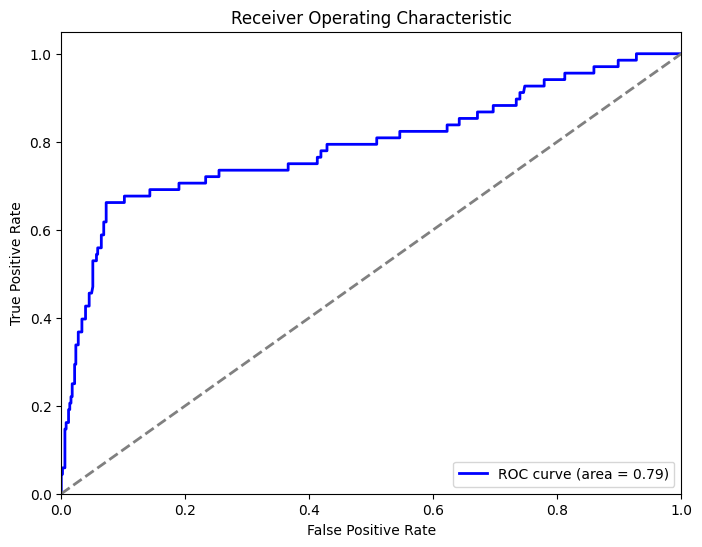

In [ ]:
import torch
from transformers import BertForSequenceClassification
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from torch.nn.functional import softmax


# Menghitung probabilitas
probabilities = []
for batch in test_loader:
    inputs = {
        'input_ids': batch['input_ids'],
        'attention_mask': batch['attention_mask']
    }

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    probs = softmax(logits, dim=1)
    probabilities.extend(probs[:, 1].tolist()) # Probabilitas kelas 1

# Menghitung nilai ROC
fpr, tpr, thresholds = roc_curve(true_labels, probabilities)
roc_auc = auc(fpr, tpr)

# Visualisasi ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Average Loss: 0.360818955066957


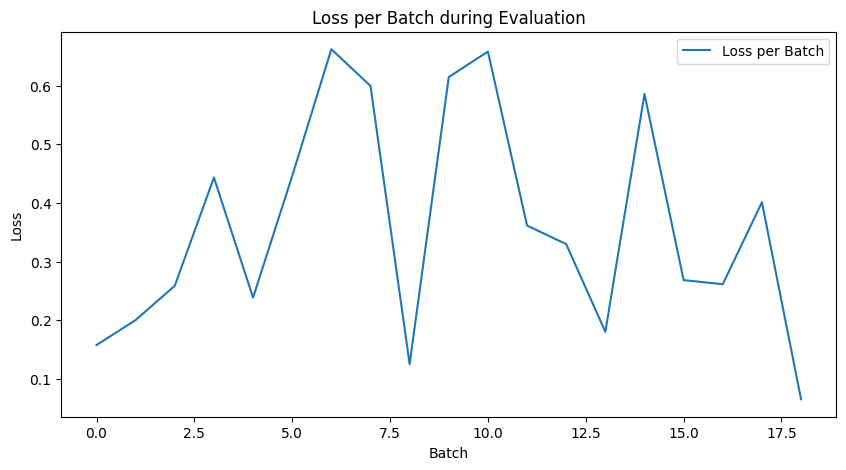

In [ ]:
from torch.nn.functional import cross_entropy

# Inisialisasi list untuk menyimpan nilai loss
loss_values = []

for batch in test_loader:
    inputs = {
        'input_ids': batch['input_ids'],
        'attention_mask': batch['attention_mask']
    }
    labels = batch['labels']

    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    # Menghitung loss menggunakan cross-entropy karena ini adalah masalah klasifikasi
    loss = cross_entropy(logits, labels)
    loss_values.append(loss.item())

# Menghitung rata-rata loss
average_loss = np.mean(loss_values)
print(f"Average Loss: {average_loss}")

# Visualisasi nilai loss
plt.figure(figsize=(10, 5))
plt.plot(loss_values, label='Loss per Batch')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Loss per Batch during Evaluation')
plt.legend()
plt.show()

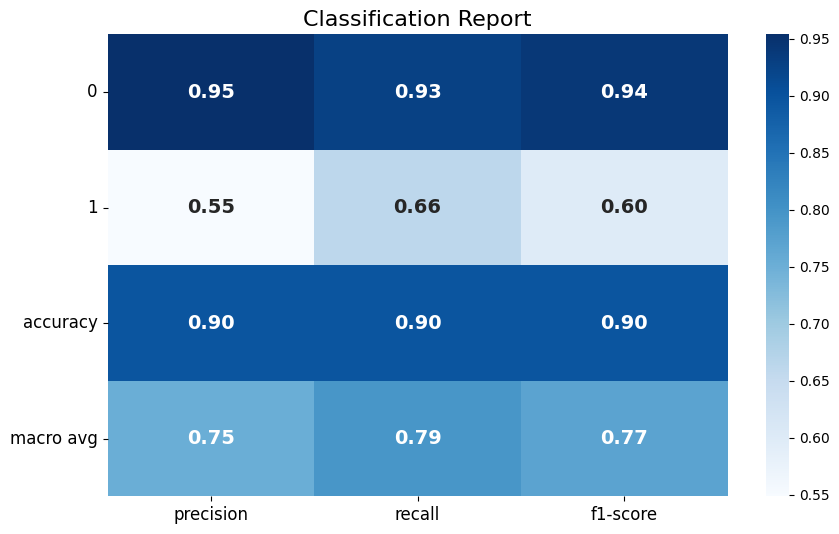

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

report = classification_report(true_labels, predictions, output_dict=True)
# Convert the classification report into a DataFrame
report_df = pd.DataFrame(report).transpose()

# Plot heatmap dengan teks yang lebih besar dan ditebalkan
plt.figure(figsize=(10, 6))
sns.heatmap(report_df.iloc[:-1, :].drop('support', axis=1), annot=True, fmt=".2f",
            cmap='Blues', annot_kws={"size": 14, "weight": "bold"})
plt.title('Classification Report', size=16)
plt.yticks(rotation=0, size=12)
plt.xticks(size=12)
plt.show()


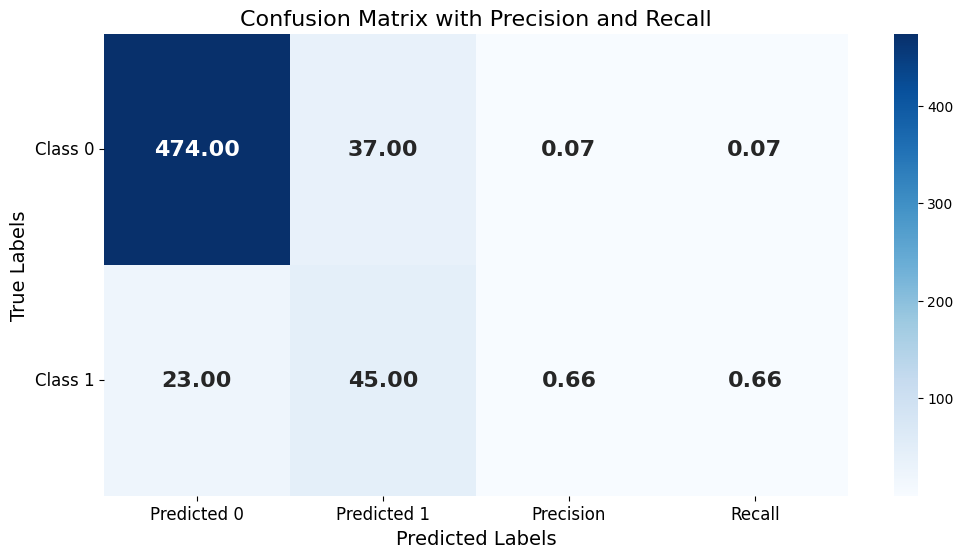

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix and convert it into a DataFrame
cm = confusion_matrix(true_labels, predictions)
cm_df = pd.DataFrame(cm, index=['Class 0', 'Class 1'], columns=['Predicted 0', 'Predicted 1'])

# Calculate the rates
cm_df['Precision'] = cm_df['Predicted 1'] / (cm_df['Predicted 1'] + cm_df['Predicted 0'])
cm_df['Recall'] = cm_df.iloc[:, 1] / (cm_df.iloc[:, 1] + cm_df.iloc[:, 0])

# Plot confusion matrix with precision and recall with text enlarged and bold
plt.figure(figsize=(12, 6))
sns.heatmap(cm_df, annot=True, fmt=".2f", cmap='Blues', annot_kws={"size": 16, "weight": "bold"})
plt.title('Confusion Matrix with Precision and Recall', size=16)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('True Labels', size=14)
plt.xticks(size=12)
plt.yticks(size=12, rotation=0)
plt.show()

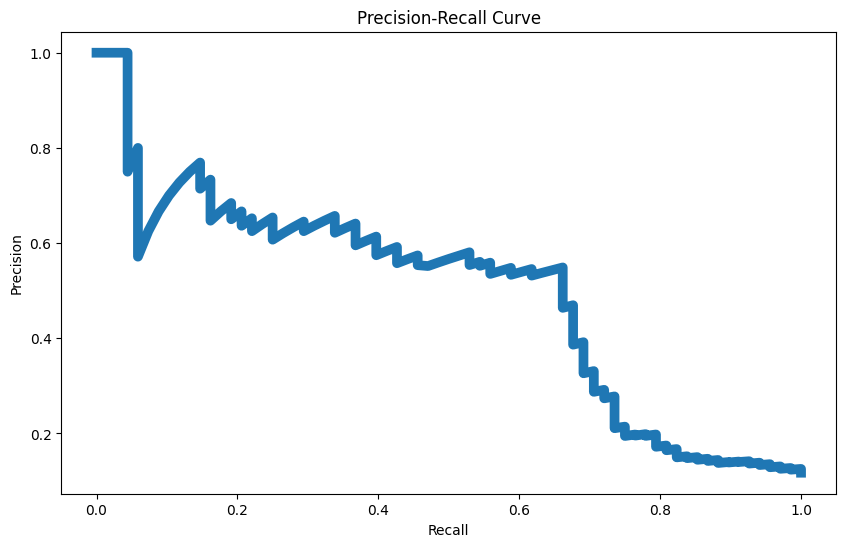

In [ ]:
from sklearn.metrics import precision_recall_curve

# Calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(true_labels, probabilities)

# Plot the precision-recall curve
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, marker='.',linewidth=7)
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

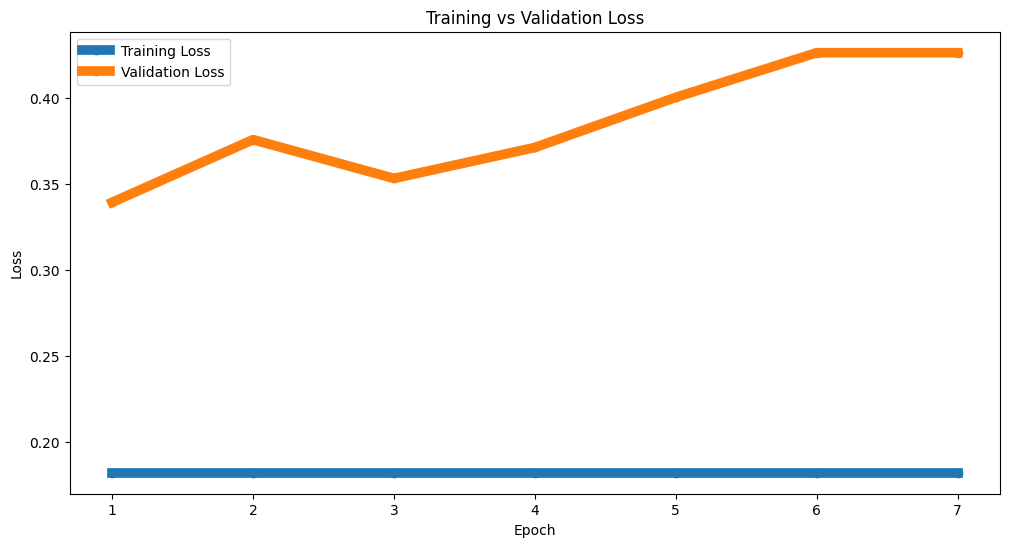

In [ ]:
import matplotlib.pyplot as plt

# Data training sesuai dengan output yang diberikan
epochs = [1, 2, 3, 4, 5, 6, 7]
training_loss = [None, None, None, None, 0.181900, 0.181900, 0.181900]  # 'No log' replaced with None
validation_loss = [0.339193, 0.375620, 0.353070, 0.371075, 0.400236, 0.426187, 0.426187]
precision = [0.520548, 0.548780, 0.541667, 0.546875, 0.552239, 0.532258, 0.532258]
recall = [0.558824, 0.661765, 0.573529, 0.514706, 0.544118, 0.485294, 0.485294]
f1 = [0.539007, 0.600000, 0.557143, 0.530303, 0.544118, 0.507692, 0.507692]
roc_auc = [0.745165, 0.794679, 0.754475, 0.728977, 0.742705, 0.714271, 0.714271]
accuracy = [0.887737, 0.896373, 0.892919, 0.892919, 0.894646, 0.889465, 0.889465]

# Replace None values with the first available log for a cleaner plot
first_log_index = next(i for i, x in enumerate(training_loss) if x is not None)
for i in range(first_log_index):
    training_loss[i] = training_loss[first_log_index]

# Plotting training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o',linewidth=7)
plt.plot(epochs, validation_loss, label='Validation Loss', marker='o',linewidth=7)
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


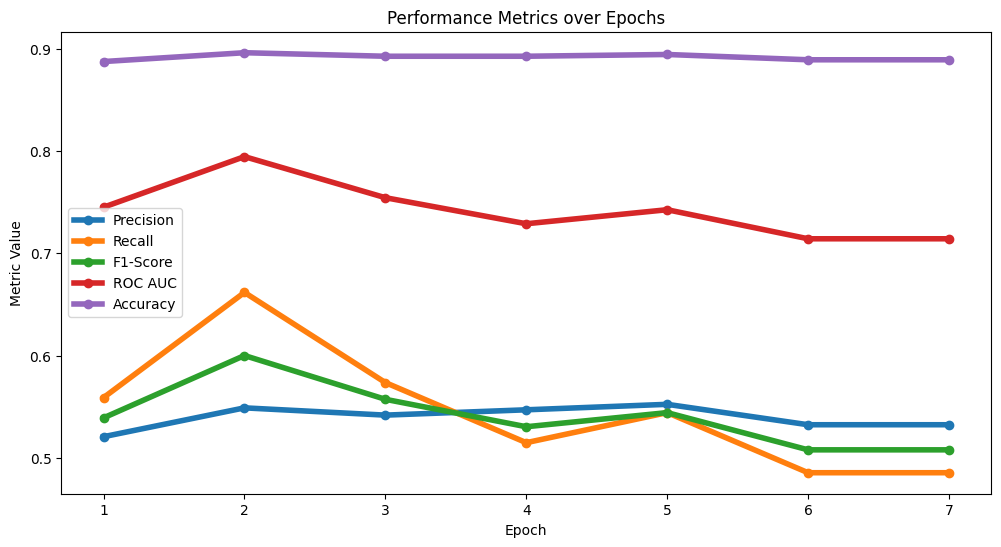

In [ ]:
# Plotting precision, recall, f1-score, roc-auc, and accuracy
plt.figure(figsize=(12, 6))
plt.plot(epochs, precision, label='Precision', marker='o',linewidth=4)
plt.plot(epochs, recall, label='Recall', marker='o',linewidth=4)
plt.plot(epochs, f1, label='F1-Score', marker='o',linewidth=4)
plt.plot(epochs, roc_auc, label='ROC AUC', marker='o',linewidth=4)
plt.plot(epochs, accuracy, label='Accuracy', marker='o',linewidth=4)
plt.title('Performance Metrics over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.legend()
plt.show()